## 📦 Importation des bibliothèques

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

## 📊 Chargement du jeu de données

In [2]:
dataset = load_dataset("ag_news")
class_names = dataset["train"].features["label"].names
print(dataset)
print(class_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
['World', 'Sports', 'Business', 'Sci/Tech']


## 🤖 Chargement du modèle pour extraire les features

In [3]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

## 🧪 Passage du modèle en mode évaluation (et test de présence GPU)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(f"Using device: {device}")

Using device: cuda


## 🛠️ Fonction utilitaire

In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

def extract_embeddings(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
    with torch.no_grad():
        outputs = model(**inputs)
    return {'embeddings': outputs.last_hidden_state[:, 0].cpu().numpy()}

## ✂️ Tokenisation

In [6]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

## 🧠 Extraction des embeddings

In [7]:
print("Extraction des embeddings pour le jeu d'entraînement...")
train_embeddings = tokenized_datasets["train"].map(extract_embeddings, batched=True, batch_size=512)
print("Extraction des embeddings pour le jeu de test...")
test_embeddings = tokenized_datasets["test"].map(extract_embeddings, batched=True, batch_size=512)

Extraction des embeddings pour le jeu d'entraînement...
Extraction des embeddings pour le jeu de test...


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

## 💾 Stockage dans des tableaux NumPy

In [8]:
X_train = np.array(train_embeddings["embeddings"])
y_train = np.array(train_embeddings["labels"])
X_test = np.array(test_embeddings["embeddings"])
y_test = np.array(test_embeddings["labels"])

print(f"\nDimensions des embeddings d'entraînement : {X_train.shape}")
print(f"Dimensions des labels d'entraînement : {y_train.shape}")


Dimensions des embeddings d'entraînement : (120000, 768)
Dimensions des labels d'entraînement : (120000,)


/tmp/ipykernel_1640/2515415211.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_train = np.array(train_embeddings["embeddings"])
/tmp/ipykernel_1640/2515415211.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train = np.array(train_embeddings["labels"])
/tmp/ipykernel_1640/2515415211.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn

## 🧱 Définition de notre modèle de classification

In [9]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.3):
        super(SimpleClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        logits = self.fc3(x) 
        return logits

## ⏱️ Paramètres du EarlyStopping

In [10]:
best_val_loss = float('inf')
patience = 5                 
epochs_no_improve = 0       
early_stop = False          
best_model_state = None

## 🔁 Entraînement du modèle

In [11]:
input_dim = X_train.shape[1]
num_classes = len(class_names)
model_classifier = SimpleClassifier(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_classifier.parameters(), lr=0.001)

train_dataset_pt = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset_pt = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset_pt, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset_pt, batch_size=512, shuffle=False)

num_epochs = 100
print("\nEntraînement du classifieur simple avec Early Stopping...")
for epoch in range(num_epochs):
    # Phase d'entraînement
    model_classifier.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)

    # Phase de validation
    model_classifier.eval() 
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_classifier(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model_classifier.state_dict() 
        print(f"  --> Nouvelle meilleure perte de validation. Sauvegarde du modèle.")
    else:
        epochs_no_improve += 1
        print(f"  --> Perte de validation non améliorée pour {epochs_no_improve} époque(s).")
        if epochs_no_improve >= patience:
            print(f"  --> Early stopping déclenché après {patience} époques sans amélioration.")
            early_stop = True
            break 

    if early_stop:
        break

if best_model_state:
    model_classifier.load_state_dict(best_model_state)
    print("\nMeilleur modèle chargé pour l'évaluation finale.")


Entraînement du classifieur simple avec Early Stopping...
Epoch 1/100, Train Loss: 0.2880, Val Loss: 0.2490
  --> Nouvelle meilleure perte de validation. Sauvegarde du modèle.
Epoch 2/100, Train Loss: 0.2387, Val Loss: 0.2372
  --> Nouvelle meilleure perte de validation. Sauvegarde du modèle.
Epoch 3/100, Train Loss: 0.2215, Val Loss: 0.2282
  --> Nouvelle meilleure perte de validation. Sauvegarde du modèle.
Epoch 4/100, Train Loss: 0.2093, Val Loss: 0.2211
  --> Nouvelle meilleure perte de validation. Sauvegarde du modèle.
Epoch 5/100, Train Loss: 0.1989, Val Loss: 0.2231
  --> Perte de validation non améliorée pour 1 époque(s).
Epoch 6/100, Train Loss: 0.1895, Val Loss: 0.2225
  --> Perte de validation non améliorée pour 2 époque(s).
Epoch 7/100, Train Loss: 0.1815, Val Loss: 0.2250
  --> Perte de validation non améliorée pour 3 époque(s).
Epoch 8/100, Train Loss: 0.1734, Val Loss: 0.2243
  --> Perte de validation non améliorée pour 4 époque(s).
Epoch 9/100, Train Loss: 0.1669, Val 

## 📉 Évaluation des performances sur le jeu de test

In [12]:
model_classifier.eval() 
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_classifier(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
y_pred = np.array(all_predictions)
y_true = np.array(all_labels)
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy on the test set: {accuracy:.4f}")
print(f"F1-score (Macro) on the test set: {f1_macro:.4f}")


Accuracy on the test set: 0.9247
F1-score (Macro) on the test set: 0.9249


## 📊 Matrice de confusion pour analyser les performances par classe

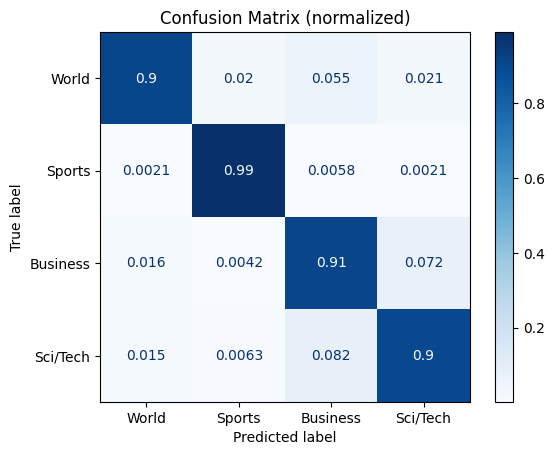

In [13]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (normalized)")
plt.show()

## 🔍 Définition d'une fonction de prédiction pour tester avec des données utilisateur

In [20]:
def predict(text_to_predict):
    inputs = tokenizer(text_to_predict, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        embedding = model(**inputs).last_hidden_state[:, 0].cpu().numpy()

    model_classifier.eval() 
    with torch.no_grad():
        logits = model_classifier(torch.tensor(embedding, dtype=torch.float32).to(device))
        probabilities = F.softmax(logits, dim=1)

        predicted_class_id = torch.argmax(probabilities, dim=1).item()

    predicted_class_name = class_names[predicted_class_id]

    print(f"\nText: '{text_to_predict}'")
    print(f"Predicted class: {predicted_class_name}")
    print(f"Probabilities for each class: {probabilities.cpu().numpy()}")

In [21]:
predict("Investors are watching the stock market closely after the interest rate hike.")


Text: 'Investors are watching the stock market closely after the interest rate hike.'
Predicted class: Business
Probabilities for each class: [[2.6670486e-02 6.6998167e-05 9.5829064e-01 1.4971885e-02]]


In [22]:
predict("The new smartphone model has received positive reviews from tech experts.")


Text: 'The new smartphone model has received positive reviews from tech experts.'
Predicted class: Sci/Tech
Probabilities for each class: [[3.6635841e-04 2.7555314e-05 1.3592272e-01 8.6368334e-01]]


In [23]:
predict("The local football team won the championship after a thrilling match.")


Text: 'The local football team won the championship after a thrilling match.'
Predicted class: Sports
Probabilities for each class: [[0.23749962 0.57897246 0.17230463 0.01122333]]


In [24]:
predict("The government has announced new policies to boost the economy.")


Text: 'The government has announced new policies to boost the economy.'
Predicted class: Business
Probabilities for each class: [[7.9495981e-02 1.1745157e-05 9.1859663e-01 1.8955708e-03]]


In [25]:
predict("The new AI model has shown significant improvements in natural language understanding.")


Text: 'The new AI model has shown significant improvements in natural language understanding.'
Predicted class: Sci/Tech
Probabilities for each class: [[3.8163252e-03 2.9300740e-05 3.4681190e-02 9.6147317e-01]]


In [28]:
predict("Le PSG remporte son premier titre, des dégradations durant la célébration")


Text: 'Le PSG remporte son premier titre, des dégradations durant la célébration'
Predicted class: Sports
Probabilities for each class: [[0.07099511 0.8973191  0.0061614  0.02552447]]


In [32]:
predict("Beaucoup d'annonces durant le salon pour les professionnels")


Text: 'Beaucoup d'annonces durant le salon pour les professionnels'
Predicted class: Sci/Tech
Probabilities for each class: [[0.27932194 0.06543742 0.17170958 0.48353106]]


In [31]:
predict("Beaucoup d'annonces durant le salon pour les professionnels de l'hotellerie et de la restauration")


Text: 'Beaucoup d'annonces durant le salon pour les professionnels de l'hotellerie et de la restauration'
Predicted class: Business
Probabilities for each class: [[0.11925057 0.00555874 0.5473516  0.3278391 ]]
